In [1]:

import random
import numpy as np
import keras
import keras.layers
import keras.applications
import keras.backend
import keras.preprocessing.image
import keras.utils
import tensorflow as tf
from coord import CoordinateChannel2D
from keras.layers import Input, Conv2D, Flatten, Softmax,Dropout,AveragePooling2D,Dense,BatchNormalization,MaxPooling2D
from keras.applications.inception_v3 import InceptionV3

Using TensorFlow backend.


In [2]:
from keras.initializers import glorot_normal
from keras.optimizers import Adam

def outer_product(x):
    """
    calculate outer-products of 2 tensors

        args 
            x
                list of 2 tensors
                , assuming each of which has shape = (size_minibatch, total_pixels, size_filter)
    """
    return keras.backend.batch_dot(x[0], x[1], axes=[1,1]) / x[0].get_shape().as_list()[1] 

def signed_sqrt(x):
    """
    calculate element-wise signed square root

        args
            x
                a tensor
    """
    return keras.backend.sign(x) * keras.backend.sqrt(keras.backend.abs(x) + 1e-9)

def L2_norm(x, axis=-1):
    """
    calculate L2-norm

        args 
            x
                a tensor
    """
    return keras.backend.l2_normalize(x, axis=axis)


def build_model(
    size_heigth=128
    ,size_width=128
    ,no_class=6
    ,no_last_layer_backbone=-3
    
    ,name_optimizer="Adam"
    ,rate_learning=1e-4
    ,rate_decay_learning=0.0
    ,rate_decay_weight=0.01
    
    ,name_initializer="glorot_normal"
    ,name_activation_logits="softmax"
    ,name_loss="categorical_crossentropy"

    ,flg_debug=True
    ,**kwargs
):
    
    keras.backend.clear_session()
    
    print("-------------------------------")
    print("parameters:")
    for key, val in locals().items():
        if not val == None and not key == "kwargs":
            print("\t", key, "=",  val)
    print("-------------------------------")
    
    ### 
    ### load pre-trained model
    ###
#     tensor_input = keras.layers.Input(shape=[size_heigth,size_width,3])
#     initial_model = VGG16(weights='imagenet', include_top=False)
    tensor_input = Input(shape=(128, 128, 1))
    out = CoordinateChannel2D()(tensor_input)
    x = Conv2D(50,5,padding='same',activation="relu")(out)
    x = Conv2D(32,5,padding='same',activation="relu")(x)
    x = Conv2D(32,5,padding='same',activation="relu")(x)
    x = Conv2D(32,5,padding='same',activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
	#	x = Conv2D(40,self.kernel_size,padding='valid',activation="relu")(x)
# 		x = Dropout(self.dropout)(x, training=True)
    x = Conv2D(32,5,padding='same',activation="relu")(x)
    x = Conv2D(32,5,padding='same',activation="relu")(x)
    x = Conv2D(32,5,padding='same',activation="relu")(x)
    x = Conv2D(32,5,padding='same',activation="relu")(x)
    x = Conv2D(32,5,padding='same',activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Conv2D(32,5,padding='same',activation="relu")(x)
    x = Conv2D(32,5,padding='same',activation="relu")(x)
    x = Conv2D(32,5,padding='same',activation="relu")(x)
    x = Conv2D(32,5,padding='same',activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)


    ### 
    ### bi-linear pooling
    ###

    # extract features from detector
    x_detector = x
    shape_detector = x
    print(type(shape_detector[1]))
    if flg_debug:
        print("shape_detector : {}".format(shape_detector))

    # extract features from extractor , same with detector for symmetry DxD model
    shape_extractor = shape_detector
    x_extractor = x_detector
    if flg_debug:
        print("shape_extractor : {}".format(shape_extractor))
        
    
    # rehape to (minibatch_size, total_pixels, filter_size)
    x_detector = keras.layers.Reshape(
            [
                16*16,32
            ])(x_detector)
    if flg_debug:
        print("x_detector shape after rehsape ops : {}".format(x_detector.shape))
        
    x_extractor = keras.layers.Reshape(
            [
               16*16,32
            ]
        )(x_extractor)
    if flg_debug:
        print("x_extractor shape after rehsape ops : {}".format(x_extractor.shape))
        
        
    # outer products of features, output shape=(minibatch_size, filter_size_detector*filter_size_extractor)
    x = keras.layers.Lambda(outer_product)(
        [x_detector, x_extractor]
    )
    if flg_debug:
        print("x shape after outer products ops : {}".format(x.shape))
        
        
    # rehape to (minibatch_size, filter_size_detector*filter_size_extractor)
    x = keras.layers.Reshape([32*32])(x)
    if flg_debug:
        print("x shape after rehsape ops : {}".format(x.shape))
        
        
    # signed square-root 
    x = keras.layers.Lambda(signed_sqrt)(x)
    if flg_debug:
        print("x shape after signed-square-root ops : {}".format(x.shape))
        
    # L2 normalization
    x = keras.layers.Lambda(L2_norm)(x)
    if flg_debug:
        print("x shape after L2-Normalization ops : {}".format(x.shape))



    ### 
    ### attach FC-Layer
    ###
    x = Dense(128,activation='relu')(x)
#     x = Dense(128,activation='relu')(x)
    x = Dropout(0.2)(x, training=True)
    x = Dense(6)(x)
    x = Softmax(axis=-1)(x)
    
    if flg_debug:
        print("x shape after Dense ops : {}".format(x.shape))
    tensor_prediction = keras.layers.Activation(name_activation_logits)(x)
    if flg_debug:
        print("prediction shape : {}".format(tensor_prediction.shape))

        

    ### 
    ### compile model
    ###
    model_bilinear = keras.models.Model(
                        inputs=[tensor_input]
                        , outputs=[tensor_prediction]
                    )
    
    
    # fix pre-trained weights

        
        
    # define optimizers
#     opt_adam = keras.optimizers.adam(
#                     lr=rate_learning
#                     , decay=rate_decay_learning
#                 )
#     opt_rms = keras.optimizers.RMSprop(
#                     lr=rate_learning
#                     , decay=rate_decay_learning
#                 )
#     opt_sgd = keras.optimizers.SGD(
#                     lr=rate_learning
#                     , decay=rate_decay_learning
#                     , momentum=0.9
#                     , nesterov=False
#                 )
#     optimizers ={
#         "adam":opt_adam
#         ,"rmsprop":opt_rms
#         ,"sgd":opt_sgd
#     }
    
    model_bilinear.compile(
        loss=name_loss
        , optimizer=Adam(lr=rate_learning, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        , metrics=['accuracy']
    )
    
    
    
    if flg_debug:
        model_bilinear.summary()
    
    return model_bilinear

In [3]:
Model=build_model()

W0819 05:18:50.649569 140209576662784 deprecation_wrapper.py:119] From /data/anaconda/envs/crystal/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0819 05:18:50.650810 140209576662784 deprecation_wrapper.py:119] From /data/anaconda/envs/crystal/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0819 05:18:50.681267 140209576662784 deprecation_wrapper.py:119] From /data/anaconda/envs/crystal/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0819 05:18:50.686090 140209576662784 deprecation_wrapper.py:119] From /data/anaconda/envs/crystal/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placehold

-------------------------------
parameters:
	 flg_debug = True
	 name_loss = categorical_crossentropy
	 name_activation_logits = softmax
	 name_initializer = glorot_normal
	 rate_decay_weight = 0.01
	 rate_decay_learning = 0.0
	 rate_learning = 0.0001
	 name_optimizer = Adam
	 no_last_layer_backbone = -3
	 no_class = 6
	 size_width = 128
	 size_heigth = 128
-------------------------------


W0819 05:18:55.131548 140209576662784 deprecation_wrapper.py:119] From /data/anaconda/envs/crystal/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0819 05:18:55.195306 140209576662784 deprecation_wrapper.py:119] From /data/anaconda/envs/crystal/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0819 05:18:55.492089 140209576662784 deprecation.py:506] From /data/anaconda/envs/crystal/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0819 05:18:55.528486 140209576662784 deprecation_wrapper.py:119] From /data/anaconda/

<class 'tensorflow.python.framework.ops.Tensor'>
shape_detector : Tensor("max_pooling2d_3/MaxPool:0", shape=(?, 16, 16, 32), dtype=float32)
shape_extractor : Tensor("max_pooling2d_3/MaxPool:0", shape=(?, 16, 16, 32), dtype=float32)
x_detector shape after rehsape ops : (?, 256, 32)
x_extractor shape after rehsape ops : (?, 256, 32)
x shape after outer products ops : (?, 32, 32)
x shape after rehsape ops : (?, 1024)
x shape after signed-square-root ops : (?, 1024)
x shape after L2-Normalization ops : (?, 1024)
x shape after Dense ops : (?, 6)
prediction shape : (?, 6)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
coordinate_channel2d_1 (Coordin

In [4]:
from keras.callbacks import ModelCheckpoint,TensorBoard,ReduceLROnPlateau
from dataLoader import data_loader

filepath = "weights-imp-{epoch:02d}-{val_acc:.2f}.hdf5"
#load any previous weight files \
#Model.load_weights("weights-imp-20-0.99.hdf5")

dataLoader = data_loader('./data/train/', './data/val/', './data/test/')
train_generator, validation_generator, test_generator = dataLoader.load_images()
checkpoint_1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
checkpoint_2 =  TensorBoard(log_dir='logs/{}', histogram_freq=0, write_graph=True, write_images=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0)
callbacks_list = [checkpoint_2,checkpoint_1,reduce_lr]
#NO. of Steps per epoch 
train_steps = np.math.ceil(train_generator.samples / train_generator.batch_size)
val_steps = np.math.ceil(validation_generator.samples / validation_generator.batch_size)
test_steps = np.math.ceil(test_generator.samples / test_generator.batch_size)

history = Model.fit_generator(train_generator, steps_per_epoch =train_steps, epochs = 20,callbacks=callbacks_list,validation_data=validation_generator,validation_steps = val_steps)
print('--------Test data--------')

x = Model.evaluate_generator(test_generator, steps = test_steps,verbose = 1)
print(x)


Found 42000 images belonging to 6 classes.
Found 9000 images belonging to 6 classes.
Found 9000 images belonging to 6 classes.


W0819 05:18:59.248925 140209576662784 deprecation.py:323] From /data/anaconda/envs/crystal/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0819 05:19:01.461631 140209576662784 deprecation_wrapper.py:119] From /data/anaconda/envs/crystal/lib/python3.6/site-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0819 05:19:01.463032 140209576662784 deprecation_wrapper.py:119] From /data/anaconda/envs/crystal/lib/python3.6/site-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/20
329/329 [==============================] - 89s 270ms/step - loss: 1.4661 - acc: 0.6930 - val_loss: 1.4484 - val_acc: 0.5958

Epoch 00001: val_acc improved from -inf to 0.59578, saving model to weights-imp-01-0.60.hdf5
Epoch 2/20
329/329 [==============================] - 85s 259ms/step - loss: 1.2415 - acc: 0.8288 - val_loss: 1.4774 - val_acc: 0.5687

Epoch 00002: val_acc did not improve from 0.59578
Epoch 3/20
329/329 [==============================] - 85s 259ms/step - loss: 1.1432 - acc: 0.9156 - val_loss: 1.3485 - val_acc: 0.7113

Epoch 00003: val_acc improved from 0.59578 to 0.71133, saving model to weights-imp-03-0.71.hdf5
Epoch 4/20
329/329 [==============================] - 85s 259ms/step - loss: 1.1156 - acc: 0.9335 - val_loss: 1.4795 - val_acc: 0.5571

Epoch 00004: val_acc did not improve from 0.71133
Epoch 5/20
329/329 [==============================] - 85s 259ms/step - loss: 1.1030 - acc: 0.9432 - val_loss: 1.1659 - val_acc: 0.8820

Epoch 00005: val_acc improved f

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


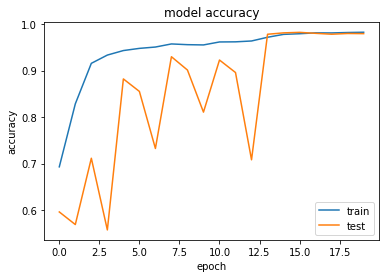

In [6]:
import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.ylim(0.8, 1.0)
plt.legend(['train', 'test'], loc='best')
plt.show()


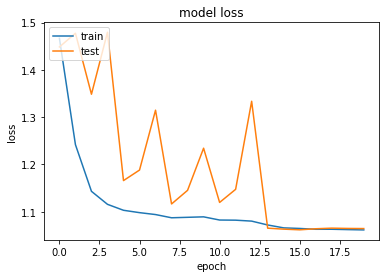

In [7]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
class_labels = ['centred', 'hexagonal', 'noise', 'oblique','rectangular','square']
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm ,classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.savefig("confusion_matrix.eps")
    return ax

In [9]:
predict = []
label =[]
i=0
#image_gererator from keras is faulty 
#Image GEnerated from Generator
for inputs , labels in test_generator:
    predict.append(np.array((np.argmax((Model.predict(inputs)),axis=-1))))
    label.append(np.array((np.argmax(labels,axis=-1))))
    i+=1
    if i >test_steps:
        break


In [10]:
import itertools
label = list(itertools.chain.from_iterable(label))
predict = list(itertools.chain.from_iterable(predict))

Normalized confusion matrix


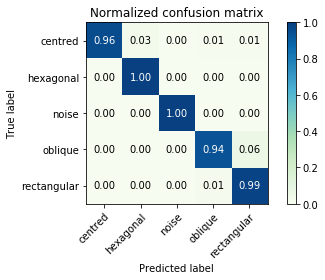

In [11]:
cm = confusion_matrix(label, predict)
plot_confusion_matrix(cm,classes=class_labels,cmap="GnBu")

In [12]:
#save log after training
import pandas as pd
acc_log = history.history['acc']
val_acc_log = history.history['val_acc']
loss_log = history.history['loss']
val_loss_log = history.history['val_loss']
acc_log = np.array(acc_log)
val_acc_log = np.array(val_acc_log)
loss_log = np.array(loss_log)
val_loss_log = np.array(val_loss_log)
mat = np.vstack((loss_log, acc_log, val_loss_log, val_acc_log))
mat = np.transpose(mat)
dataframe1 = pd.DataFrame(data=mat)
dataframe1.to_csv('save_log.csv', sep=',', header=False, float_format='%.7f', index=False)

In [13]:
data_log= pd.read_csv('save_log.csv', sep=',', header=None)

In [14]:
data_log

,0,1,2,3
0,1.466624,0.692857,1.448442,0.595778
1,1.241900,0.828357,1.477367,0.568667
2,1.143247,0.915571,1.348475,0.711333
3,1.115754,0.933333,1.479508,0.557111
4,1.103169,0.943048,1.165926,0.882000
5,1.098168,0.947738,1.188183,0.855111
6,1.094134,0.950619,1.314727,0.732333
7,1.087330,0.957286,1.116530,0.929778
8,1.088310,0.955714,1.145354,0.901111
9,1.089294,0.955143,1.234379,0.810556
